# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [3]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

backend module://ipykernel.pylab.backend_inline version unknown


In [4]:
import os
import numpy as np
import xarray as xr

In [5]:
import datetime

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [6]:
#DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [7]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [9]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['Chl']['Chl'],df['pCO2']['pCO2']], axis=1)

In [79]:
SOM_input.shape
#SOM_input.head()

(17275735, 9)

In [80]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

# Create month specific dataframes

In [ ]:
SOM_input.set_index(pd.DatetimeIndex(SOM_input['time']))

In [15]:
SOM_input['month'] = pd.DatetimeIndex(SOM_input['time']).month

In [16]:
January = SOM_input.loc[SOM_input['month'] == 1]

In [17]:
January.shape

(1477260, 9)

In [ ]:
January.reset_index(drop=True)

In [18]:
January = January.drop(columns=['time','month'])

In [72]:
sample = January.sample(10000)

In [32]:
sample.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

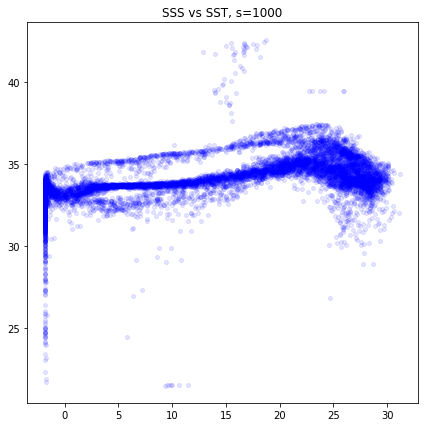

In [28]:
fig = plt.figure()
plt.plot(sample['SST'],sample['SSS'],'ob',alpha=0.1, markersize=4)
plt.title('SSS vs SST, s=1000')
fig.set_size_inches(7,7)

## Scatterplot Matrix for quickview of data relationships prior to model build

In [31]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e2b4790>,
      dtype=object)

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans (u'/Users/cg/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


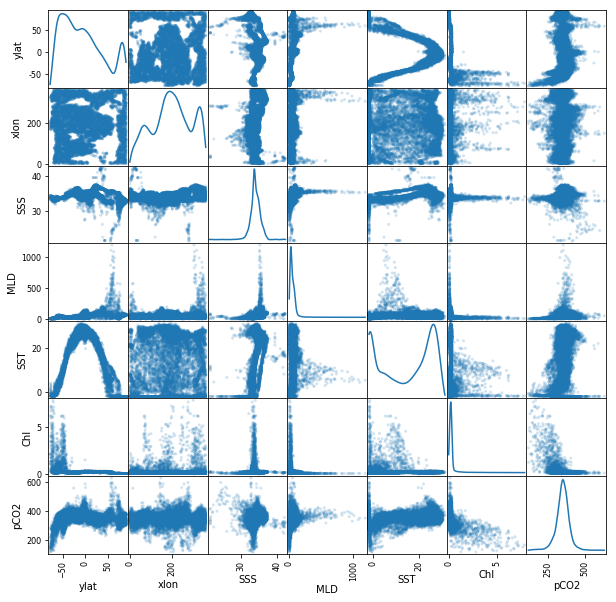

In [34]:
scatter_matrix(sample, alpha=0.2, figsize=(10,10), grid=False, diagonal='kde')

## Interesting notes
* See miniature map ylat v xlon
* Interesting SST v ylat
* Chl... looks like high  Chl content in antarctic, and not much use spatially otherwise (see Chl v xlon)
* MLD v ylat, can see 'zone' of higher MLD, same with xlon. Is this Atlantic Ocean? 

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [24]:
from sklearn.preprocessing import StandardScaler

In [148]:
#sample_scatter[['SSS','SST']] = StandardScaler().fit_transform(sample_scatter[['SSS','SST']])

In [75]:
ss = StandardScaler().fit_transform(sample[['SSS','SST','MLD','pCO2','Chl']])

In [76]:
ss.shape

(10000, 5)

In [84]:
#sample_nd = sample.as_matrix()

In [77]:

mapsize = [50,50]
som = sompy.SOMFactory.build(ss, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything


 Training...
 pca_linear_initialization took: 0.055000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 8

 epoch: 1 ---> elapsed time:  0.500000, quantization error: 1.116271

 epoch: 2 ---> elapsed time:  0.509000, quantization error: 0.781096

 epoch: 3 ---> elapsed time:  0.505000, quantization error: 0.629174

 epoch: 4 ---> elapsed time:  0.501000, quantization error: 0.558418

 epoch: 5 ---> elapsed time:  0.600000, quantization error: 0.509904

 epoch: 6 ---> elapsed time:  0.609000, quantization error: 0.457432

 epoch: 7 ---> elapsed time:  0.614000, quantization error: 0.401702

 epoch: 8 ---> elapsed time:  0.612000, quantization error: 0.343916

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.495000, quantization error: 0.286029

 epoch: 2 ---> elapsed time:  0.510000, quantization error: 0.274694

 epoch: 3 ---> elapsed time:  0.605000, quantization error: 0.264669

 ep

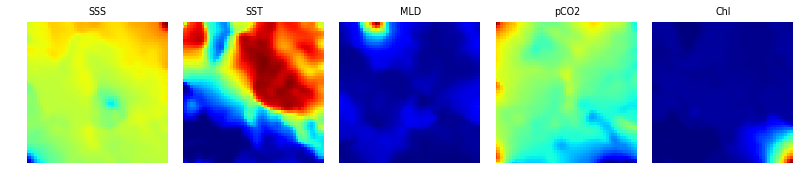

In [63]:
som.component_names = ['SSS','SST','MLD','pCO2','Chl']
v = sompy.mapview.View2DPacked(20, 20, '',text_size=8)  
v.show(som, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default


In [68]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(5, 2, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl = som.cluster(n_clusters=5)
# print cl
getattr(som, 'cluster_labels')

array([0, 3, 3, ..., 1, 1, 1], dtype=int32)

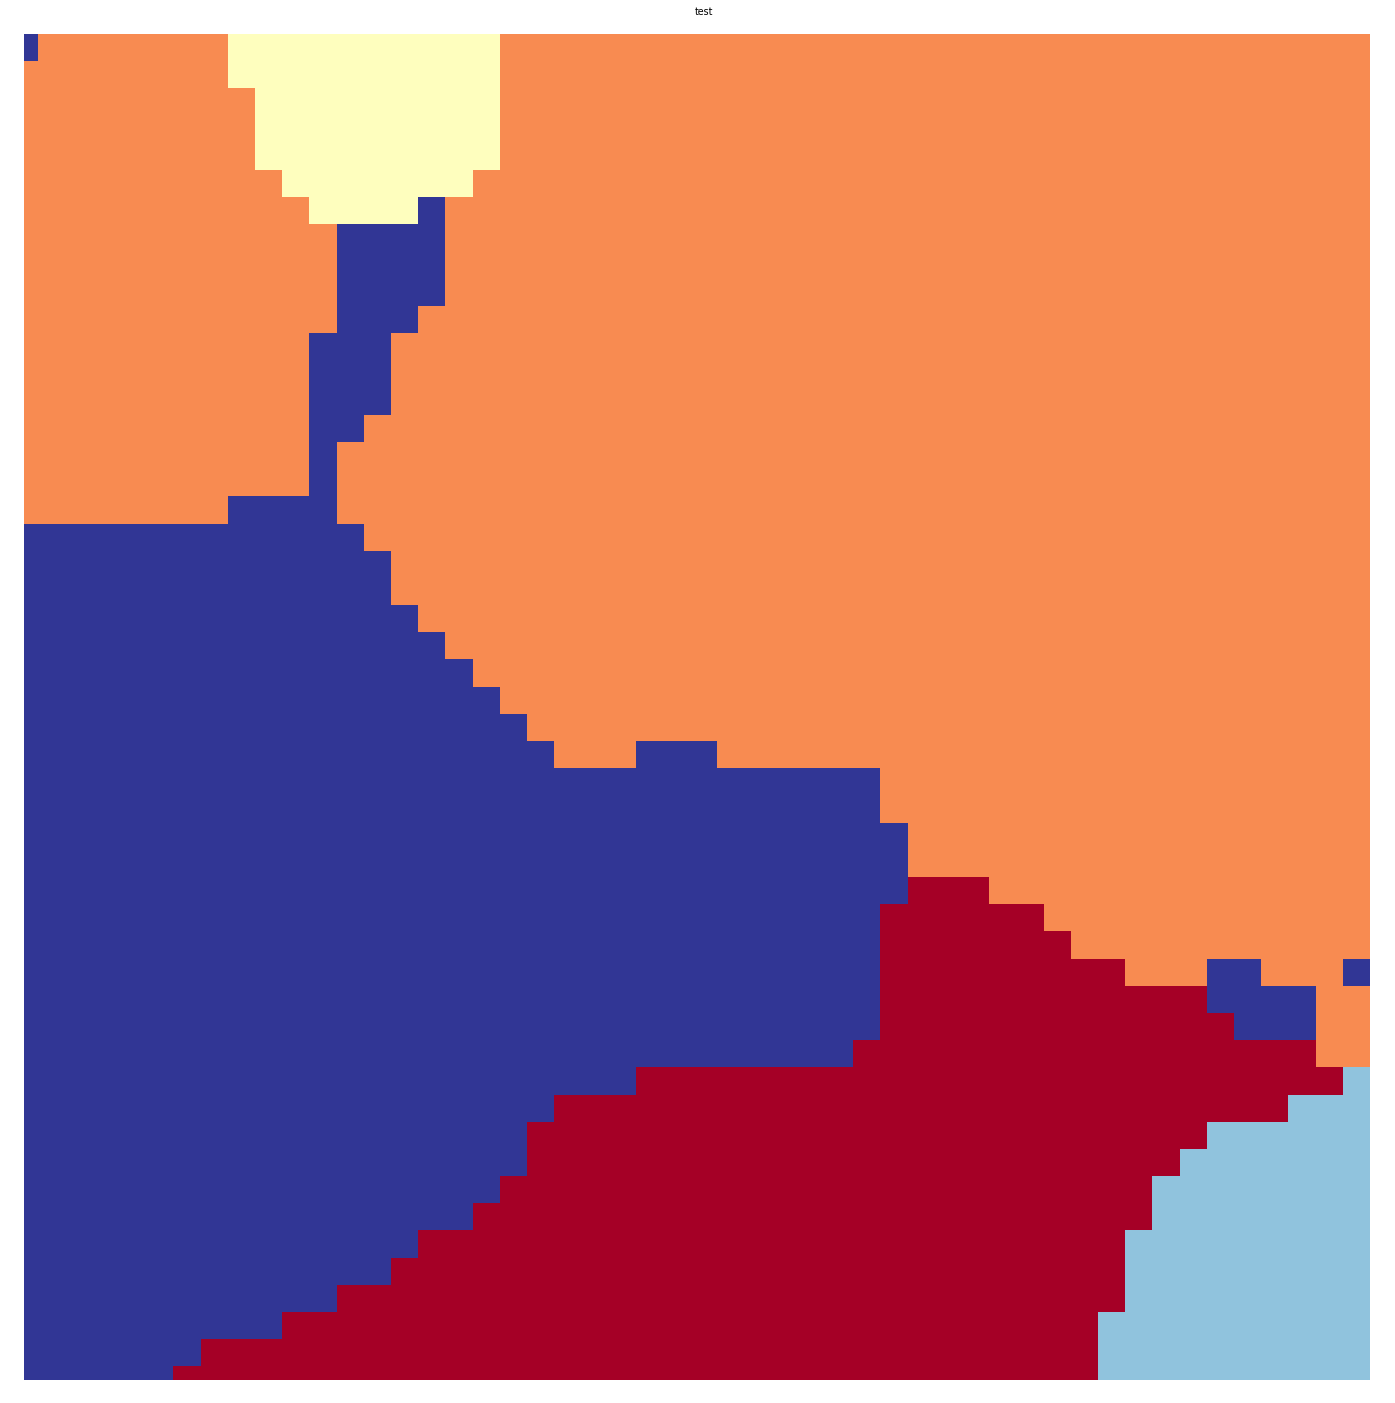

In [69]:
v.show(som, what='cluster')

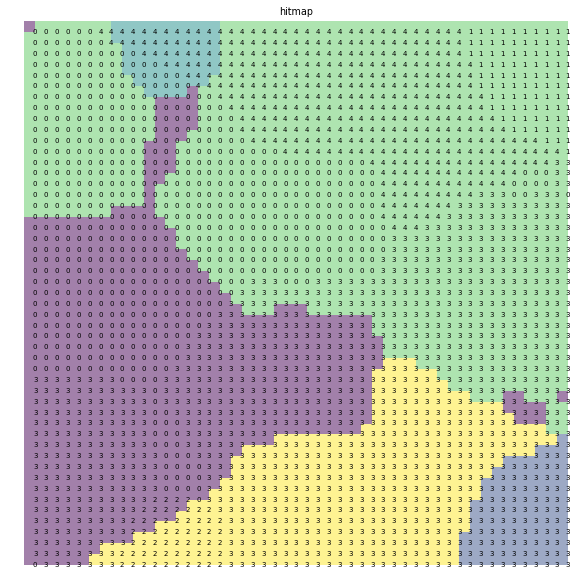

In [70]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

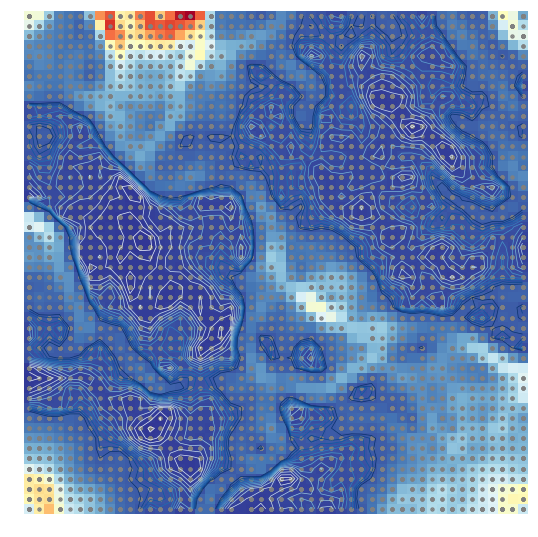

In [71]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


# TO DO
* Interpret hitmap and u-matrix more.. pretty but what can be learned?
* Try with other combos, e.g., No Chl or log(MLD) per Landschutzer
* Perform tuning exercise to choose model with lowest error
* Validate conversion of SOM results back to cluster designation for raw data (e.g., translation of neuron results to all raw data points based on centroid/BMU value)
* Validate that "clustering" method described using k-means above, post model-build, is what we're looking for

In [104]:
%matplotlib inline
import math
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

In [86]:
January_v2 = January.drop(columns=['Chl'])

In [92]:
#log(MLD)
January_v2[['MLD']] = January[['MLD']].apply(np.log)

In [93]:
January_v2.head()

,ylat,xlon,SSS,MLD,SST,pCO2
0,-77.5,179.5,34.000992,2.784570,1.648732,151.525853
1,-77.5,180.5,33.941429,2.715717,1.528921,150.330599
2,-77.5,181.5,33.863464,2.644176,1.350243,148.500409
3,-77.5,182.5,33.775764,2.570496,1.119088,146.198458
4,-77.5,183.5,33.691376,2.512309,0.865820,143.769723


In [100]:
names = ['SSS','SST','MLD','pCO2']
ss2 = StandardScaler().fit_transform(January_v2[names])

In [101]:
import random

In [ ]:
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study 
for i in range(5): 
    sm = sompy.SOMFactory().build(ss2, 
                            mapsize=[random.choice(list(range(15, 25))), 
                                     random.choice(list(range(10, 15)))], 
                            normalization = 'var', initialization='random', 
                            component_names=names, lattice="rect") 
    sm.train(n_job=4, 
             verbose=False, 
             train_rough_len=30, 
             train_finetune_len=100) 
    
    joblib.dump(sm, "model_{}.joblib".format(i))

In [ ]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

In [ ]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()